# Previsão de Precificação de Alugueis de Casas em *NY*

**Desafio Proposto:**

O objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.

**Contexto:**

Você foi alocado(a) em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.


## Importações

In [9]:
# Instalando Libs
!pip install category_encoders

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
import pickle

import warnings
warnings.filterwarnings('ignore')

In [12]:
dataframe = pd.read_csv('teste_indicium_precificacao.csv')
dataframe.shape

(48894, 16)

## Visualização e Informações do Dataset

In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [14]:
dataframe.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# Análise Exploratória dos Dados (EDA)

In [15]:
dataframe.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Alguns pontos interessantes a se notar com o describe():

A variável objetivo `price` tem:
  - Média de preço: $ 152.72

  - Valor máximo: $ 10000

  - Valor mínimo: $ 0

  Observação: Esse valor 0 não faz muito sentido no contexto do problema, deverá ser analisado.


A variável `minimo_noites` tem:
  - Média: 7 (noites)
  - Valor máximo: 1250 (noites)
  - Valor mínimo: 1 (noite)

In [16]:
# Identificando as variáveis numéricas e categóricas
numerical_columns = dataframe.select_dtypes(include=['number']).columns
categorical_columns = dataframe.select_dtypes(include=['object']).columns

print("Variáveis Numéricas:")
print(numerical_columns)

print("\nVariáveis Categóricas:")
print(categorical_columns)

Variáveis Numéricas:
Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimo_noites',
       'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365'],
      dtype='object')

Variáveis Categóricas:
Index(['nome', 'host_name', 'bairro_group', 'bairro', 'room_type',
       'ultima_review'],
      dtype='object')


## Variáveis Numéricas

In [17]:
numerical_columns_treated = numerical_columns.drop(['id', 'host_id'])

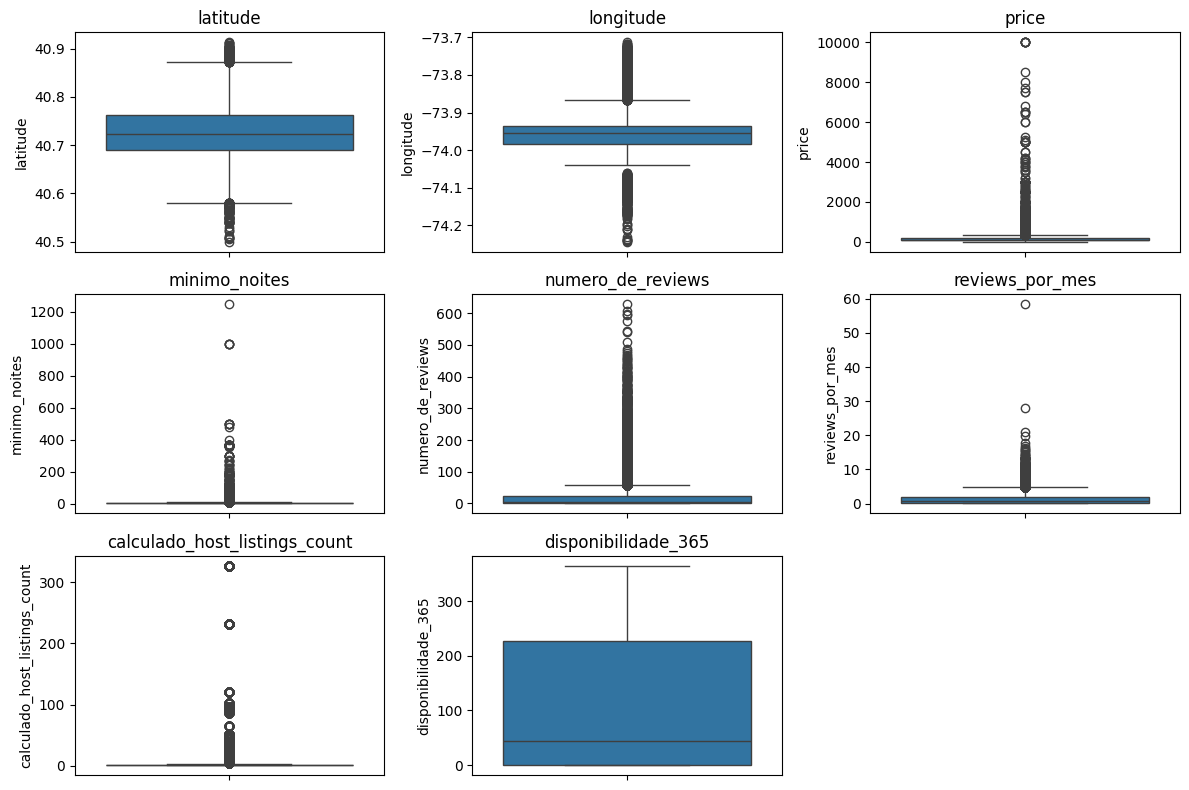

In [18]:
# Plotando Boxplots das variáveis
plt.figure(figsize=(12, 8))

for i, col in enumerate(numerical_columns_treated, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=dataframe[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Analisando os gráficos de Boxplot de todas as variáveis numéricas, percebe-se que é comum haver "anomalias" nessas variáveis e isso não deve ser alterado (removido) devido ao contexto do dataset. Contudo, a variável objetivo que será a `price` deve ser ter seus outliers analisados para serem tratados.

In [19]:
# Verificando informações de preços de casas que são mais altos
high_prices = dataframe[dataframe['price'] > 6500]
high_prices

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
4376,2953058,Film Location,1177497,Jessica,Brooklyn,Clinton Hill,40.69137,-73.96723,Entire home/apt,8000,1,1,2016-09-15,0.03,11,365
6529,4737930,Spanish Harlem Apt,1235070,Olson,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,2015-01-02,0.02,1,0
9150,7003697,Furnished room in Astoria apartment,20582832,Kathrine,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,2016-02-13,0.04,1,0
12341,9528920,"Quiet, Clean, Lit @ LES & Chinatown",3906464,Amy,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,2016-01-01,0.14,1,83
17691,13894339,Luxury 1 bedroom apt. -stunning Manhattan views,5143901,Erin,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,2017-07-27,0.16,1,0
29237,22436899,1-BR Lincoln Center,72390391,Jelena,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,NaN,NaN,1,83
29661,22779726,East 72nd Townhouse by (Hidden by Airbnb),156158778,Sally,Manhattan,Upper East Side,40.76824,-73.95989,Entire home/apt,7703,1,0,NaN,NaN,12,146
30267,23377410,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,18128455,Rum,Manhattan,Tribeca,40.72197,-74.00633,Entire home/apt,8500,30,2,2018-09-18,0.18,1,251
40432,31340283,2br - The Heart of NYC: Manhattans Lower East ...,4382127,Matt,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999,30,0,NaN,NaN,1,365
42522,33007610,70' Luxury MotorYacht on the Hudson,7407743,Jack,Manhattan,Battery Park City,40.71162,-74.01693,Entire home/apt,7500,1,0,NaN,NaN,1,364


Dos cinco distritos de NY (Queens, Brooklyn, Bronx, Manhattan e Staten Island), o que se caracteriza por ter alugueis mais caros é **Manhattan**, sendo os seguintes bairros:
  - Tribeca
  - Soho
  - Upper East Side
  - West Village

Dado essa pesquisa, estarei considerando como outliers e removendo valores que não se encaixam nas características acima, bem como analisando também as outras variáveis do dataframe, como por exemplo a disponibilidade e mínimo de noites. Dessa forma, pode ocorrer a remoção de registros que estejam, por exemplo, em um dos bairros acima, caso outras variáveis indiquem que é uma anomalia. Vale lembrar que a remoção desses outliers também acontece para não enviezar o modelo.

Outra observação, é que foi definido como limite acima 6.500, uma vez que eu pesquisei o preço médio de aluguel de NY e é entre 5.500 e 6.000.



In [20]:
# Removendo registros acima de 9k
outlier_value = 9000
outlier_index = dataframe[dataframe['price'] > outlier_value].index
dataframe = dataframe.drop(outlier_index)

In [21]:
# Removendo registro do Clinton Hill mostrado acima
outlier_value = 8000
outlier_bairro_group = "Brooklyn"
outlier_bairro = "Clinton Hill"

outlier_index = dataframe[
    (dataframe['price'] == outlier_value) &
    (dataframe['bairro_group'] == outlier_bairro_group) &
    (dataframe['bairro'] == outlier_bairro)
].index

dataframe = dataframe.drop(outlier_index)

# Removendo registro do Battery Park City
outlier_value = 7500
outlier_bairro_group = "Manhattan"
outlier_bairro = "Battery Park City"

outlier_index = dataframe[
    (dataframe['price'] == outlier_value) &
    (dataframe['bairro_group'] == outlier_bairro_group) &
    (dataframe['bairro'] == outlier_bairro)
].index

dataframe = dataframe.drop(outlier_index)

# Removendo registro do Chelsea
outlier_value = 6800
outlier_bairro_group = "Manhattan"
outlier_bairro = "Chelsea"

outlier_index = dataframe[
    (dataframe['price'] == outlier_value) &
    (dataframe['bairro_group'] == outlier_bairro_group) &
    (dataframe['bairro'] == outlier_bairro)
].index

dataframe = dataframe.drop(outlier_index)

# Removendo registro do East Flatbush
outlier_value = 7500
outlier_bairro_group = "Brooklyn"
outlier_bairro = "East Flatbush"

outlier_index = dataframe[
    (dataframe['price'] == outlier_value) &
    (dataframe['bairro_group'] == outlier_bairro_group) &
    (dataframe['bairro'] == outlier_bairro)
].index

dataframe = dataframe.drop(outlier_index)

Como mostrado acima, existem anuncios com valor mínimo de **0**, o que não faz muito sentido no contexto de alugueis de imóveis, irei analisar esses valores e suas ocorrências.

In [22]:
# Verificando valores 0
zero_prices = dataframe[dataframe['price'] == 0]
zero_prices

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
23160,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25432,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25633,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25752,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25777,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73
25793,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,2019-06-15,4.28,6,176
25794,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,2019-06-21,4.37,6,232
25795,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,2019-06-23,4.35,6,222
26258,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,NaN,NaN,1,0
26840,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,2019-06-22,0.11,6,333


In [23]:
# Removendo registros com preço 0
outlier_value = 0
outlier_index = dataframe[dataframe['price'] == outlier_value].index
dataframe = dataframe.drop(outlier_index)

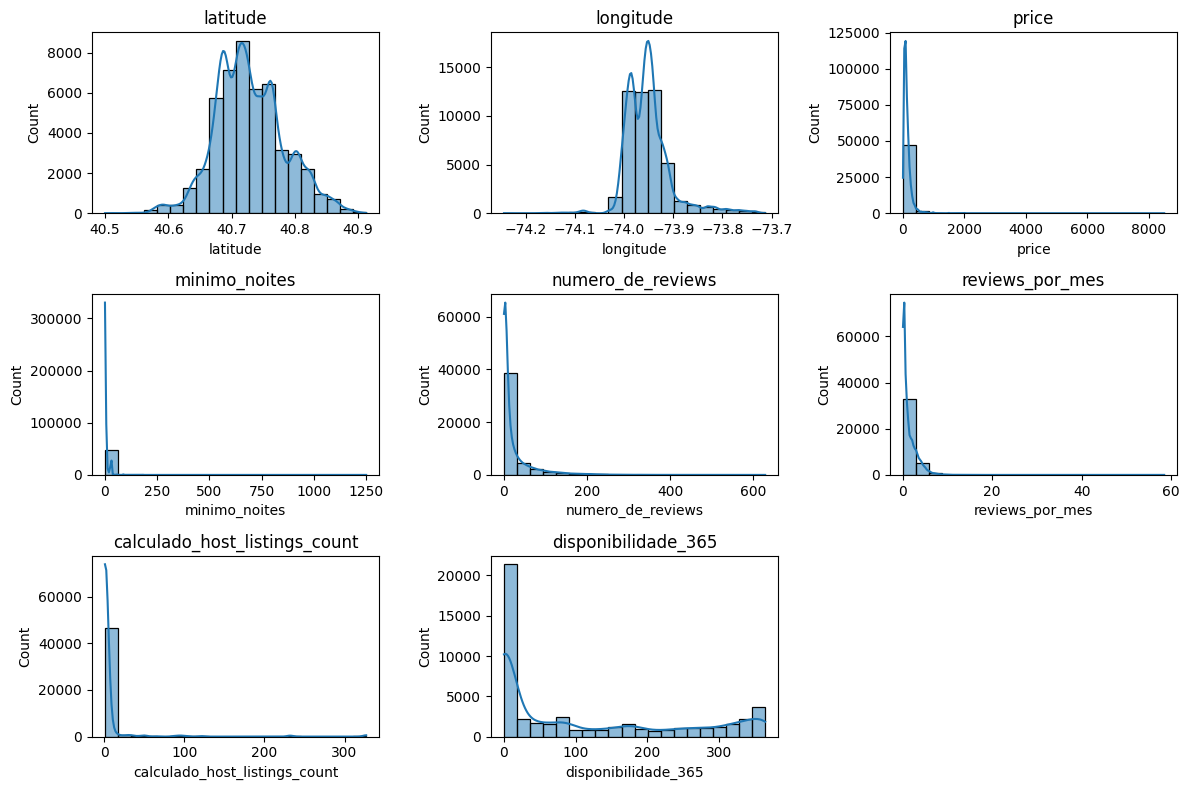

In [24]:
# Plotando Histogramas das variáveis
plt.figure(figsize=(12, 8))

for i, col in enumerate(numerical_columns_treated, 1):
    plt.subplot(3, 3, i)
    sns.histplot(x=dataframe[col], kde=True, bins=20)
    plt.title(col)

plt.tight_layout()
plt.show()

Nota-se que apenas a variável latitude tem distribuição aproximada da distribuição normal. As demais variáveis em sua maioria tem distribuição assimétrica a direita, isso indica que existem alguns outliers nessas variáveis. A transformação dessas variáveis dependerá do algoritmo do modelo e da importância delas para ele.

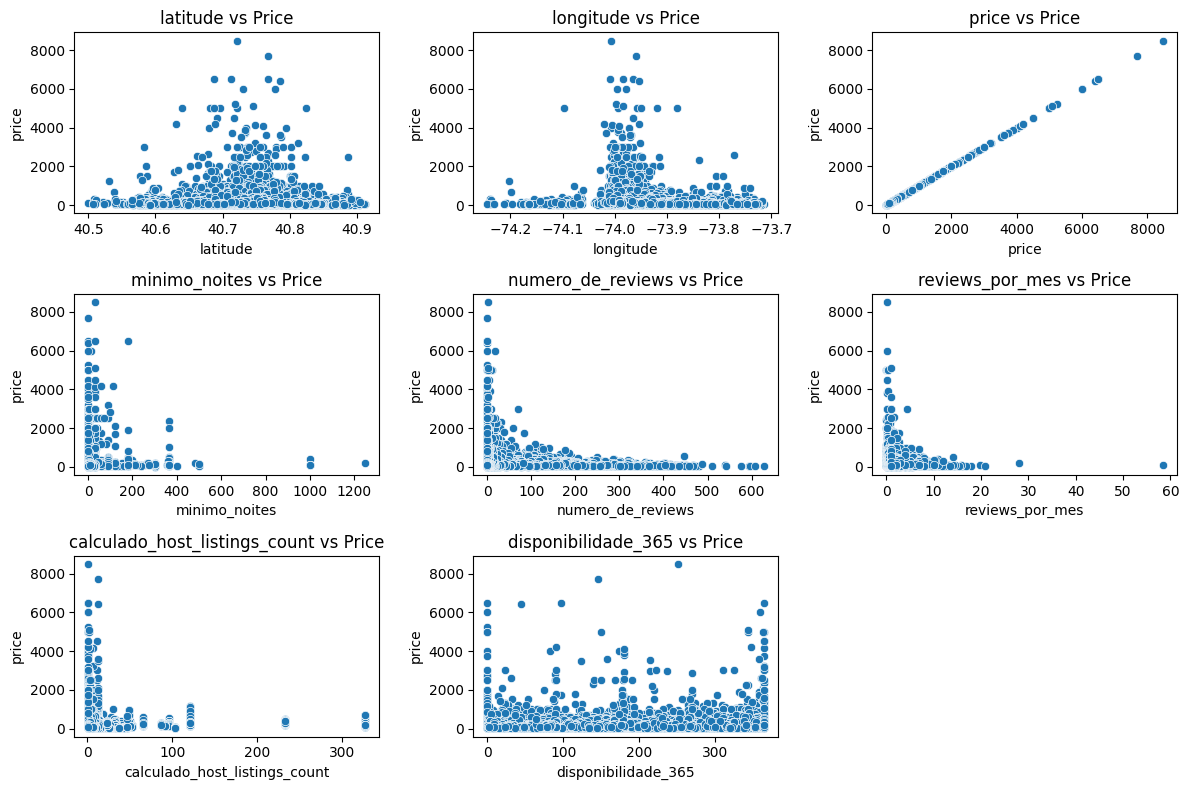

In [25]:
# Plotando Gráficos de Dispersão das Variáveis com a Target
plt.figure(figsize=(12, 8))

for i, col in enumerate(numerical_columns_treated, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=dataframe[col], y=dataframe['price'])
    plt.title(f'{col} vs Price')

plt.tight_layout()
plt.show()

Inicialmente respondendo uma das questões pedidas no desafio, percebe-se que `minimo_noites` e `disponibilidade` não possuem muita associação com a variável objetivo `price`. Contudo, e verificando mais a frente nos gráficos de correlação, nenhuma das variáveis tem uma relação alta com price, isso signica que o desempenho do modelo pode futuramente ser baixo.

## Correlações das Variáveis Numéricas

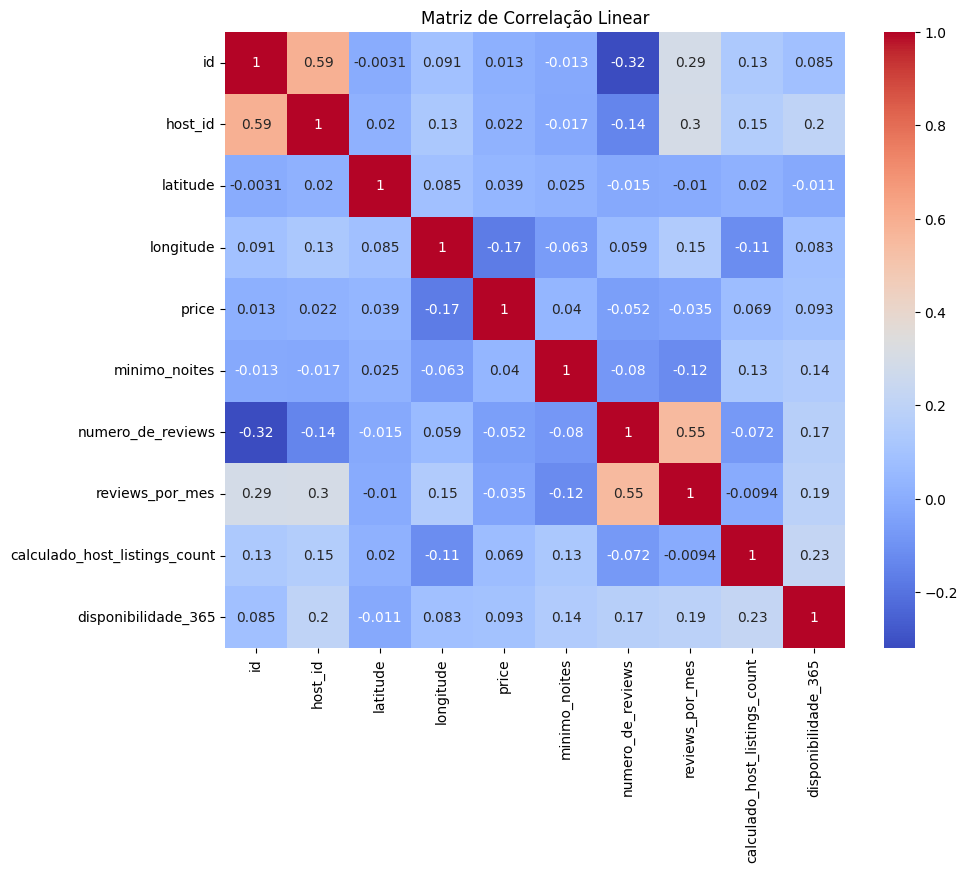

In [26]:
# Gráfico de Correlação de Pearson
plt.figure(figsize=(10, 8))
df_numerical_columns = dataframe[numerical_columns]
sns.heatmap(df_numerical_columns.corr(method='pearson'), annot=True, cmap='coolwarm')

plt.title('Matriz de Correlação Linear')
plt.show()


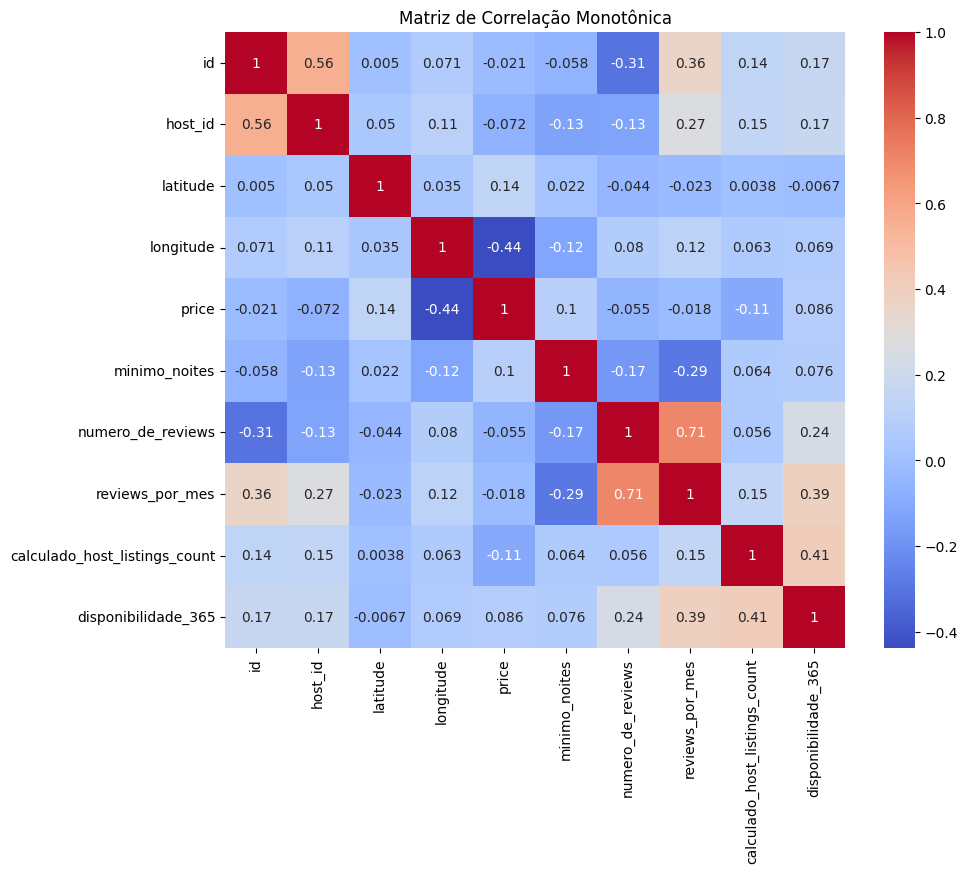

In [27]:
# Gráfico de Correlação de Spearman
plt.figure(figsize=(10, 8))
df_numerical_columns = dataframe[numerical_columns]
sns.heatmap(df_numerical_columns.corr(method='spearman'), annot=True, cmap='coolwarm')

plt.title('Matriz de Correlação Monotônica')
plt.show()

## Variáveis Categóricas

In [28]:
df_categorical_columns = dataframe[categorical_columns]
df_categorical_columns.head(1)

,nome,host_name,bairro_group,bairro,room_type,ultima_review
0,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt,2019-05-21


In [29]:
nome = dataframe.groupby(['nome']).size().sort_values(ascending=False)
nome

,0
nome,
Hillside Hotel,18
Home away from home,17
New york Multi-unit building,16
Brooklyn Apartment,12
Loft Suite @ The Box House Hotel,11
...,...
"Cozy house , very quiet , clean room !",1
Cozy house in Sunnyside gardens,1
Cozy in Bedstuy,1


In [30]:
# Verificando se existe padrão de nomes de locais de alto valor
dataframe.groupby('nome')['price'].mean().sort_values(ascending=False).head(10)

,price
nome,
Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,8500.0
East 72nd Townhouse by (Hidden by Airbnb),7703.0
SUPER BOWL Brooklyn Duplex Apt!!,6500.0
Luxury TriBeCa Apartment at an amazing price,6500.0
Apartment New York \nHell’s Kitchens,6500.0
Park Avenue Mansion by (Hidden by Airbnb),6419.0
UWS 1BR w/backyard + block from CP,6000.0
Luxury townhouse Greenwich Village,6000.0
"SuperBowl Penthouse Loft 3,000 sqft",5250.0


Percebe-se grande repetição de palavras como *Luxury* e *SuperBowl* ou nome do bairro/localidade, sobretudo, dos que conhecidamente possuem imóveis mais caros.

In [31]:
host_name = dataframe.groupby(['host_name']).size().sort_values(ascending=False)
host_name

,0
host_name,
Michael,417
David,403
Sonder (NYC),327
John,293
Alex,279
...,...
Jerbean,1
Jerald,1
Jeonghoon,1


In [32]:
bairro_group = dataframe.groupby(['bairro_group']).size().sort_values(ascending=False)
bairro_group

,0
bairro_group,
Manhattan,21654
Brooklyn,20091
Queens,5665
Bronx,1090
Staten Island,373


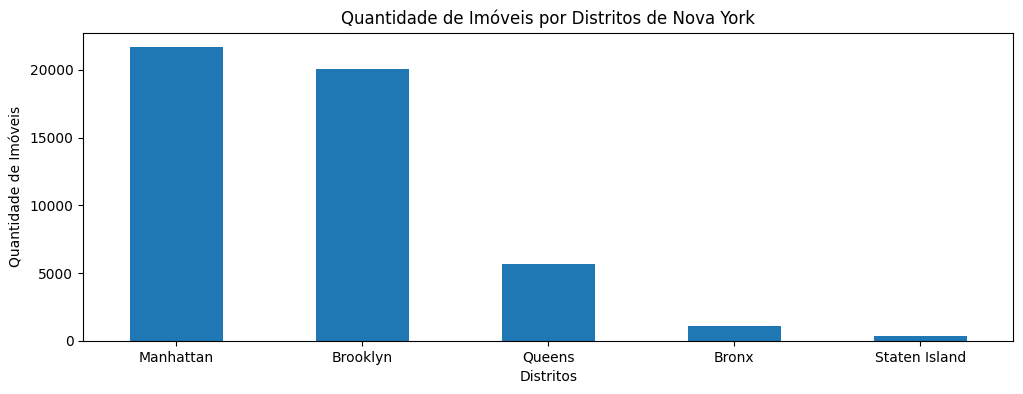

In [33]:
# Plotando gráfico do grupo de distritos de NY
plt.figure(figsize=(12, 4))
df_categorical_columns['bairro_group'].value_counts().plot(kind='bar')
plt.title('Quantidade de Imóveis por Distritos de Nova York')
plt.xlabel('Distritos')
plt.ylabel('Quantidade de Imóveis')
plt.xticks(rotation=0)
plt.show()

In [34]:
mean_prices = dataframe.groupby('bairro_group')['price'].mean()
print(f"Média de Preços por Distrito: {mean_prices}")

Média de Preços por Distrito: bairro_group
Bronx             87.577064
Brooklyn         123.187049
Manhattan        194.431976
Queens            97.769991
Staten Island    114.812332
Name: price, dtype: float64


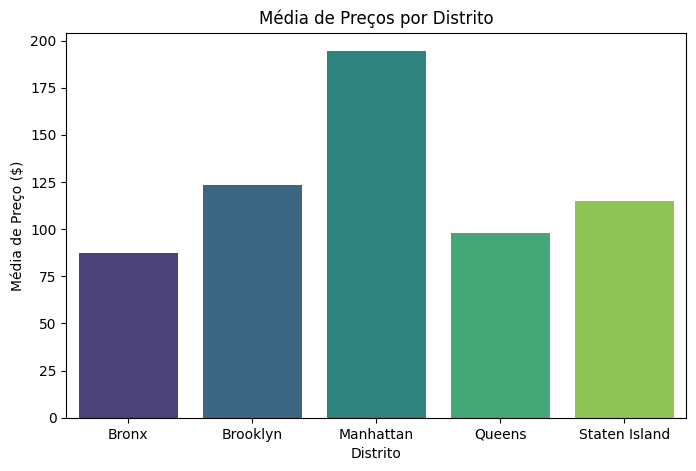

In [35]:
# Plotando o gráfico das médias dos distritos (preço)
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_prices.index, y=mean_prices.values, palette="viridis")
plt.xlabel("Distrito")
plt.ylabel("Média de Preço ($)")
plt.title("Média de Preços por Distrito")
plt.xticks(rotation=0)
plt.show()

In [36]:
bairro = dataframe.groupby(['bairro']).size().sort_values(ascending=False)
bairro

,0
bairro,
Williamsburg,3919
Bedford-Stuyvesant,3710
Harlem,2658
Bushwick,2462
Upper West Side,1970
...,...
Richmondtown,1
Willowbrook,1
Fort Wadsworth,1


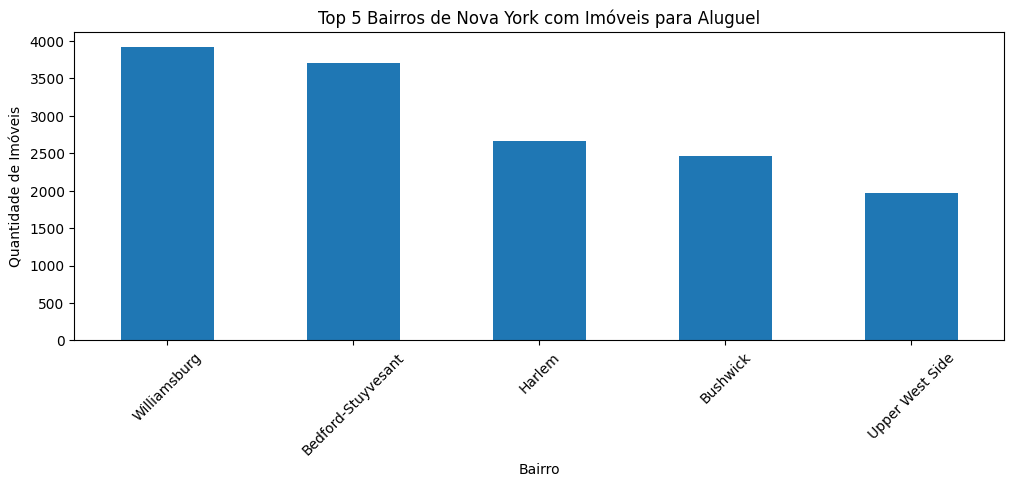

In [37]:
# Plotando gráfico dos 5 bairros com maior ocorrência
top5_bairros = dataframe['bairro'].value_counts().head(5)
plt.figure(figsize=(12, 4))
top5_bairros.plot(kind='bar')
plt.title('Top 5 Bairros de Nova York com Imóveis para Aluguel')
plt.xticks(rotation=45)
plt.xlabel('Bairro')
plt.ylabel('Quantidade de Imóveis')
plt.show()

In [38]:
mean_bairro_prices = dataframe.groupby('bairro')['price'].mean().sort_values(ascending=False).head(5)
print(f"Média de Preços do Top 5 Bairros: {mean_bairro_prices}")

Média de Preços do Top 5 Bairros: bairro
Fort Wadsworth    800.000000
Woodrow           700.000000
Tribeca           490.638418
Sea Gate          487.857143
Riverdale         442.090909
Name: price, dtype: float64


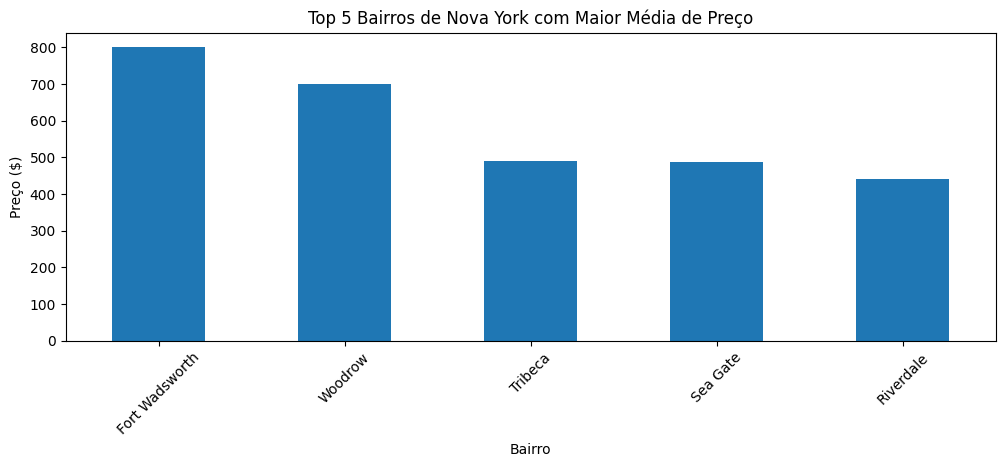

In [39]:
# Plotando Gráfico de Top 5 Bairros com Maior Média de Preço
plt.figure(figsize=(12, 4))
mean_bairro_prices.plot(kind='bar')
plt.title('Top 5 Bairros de Nova York com Maior Média de Preço')
plt.xticks(rotation=45)
plt.xlabel('Bairro')
plt.ylabel('Preço ($)')
plt.show()

Distrito dos bairros com maior média de preço:
  - Fort Wadsworth – **Staten Island**
  - Woodrow – **Staten Island**
  - Tribeca – **Manhattan**
  - Sea Gate – **Brooklyn**
  - Riverdale – **Bronx**

In [40]:
mean_bairro_prices2 = dataframe.groupby('bairro')['price'].mean()

In [41]:
room_type = dataframe.groupby(['room_type']).size().sort_values(ascending=False)
room_type

,0
room_type,
Entire home/apt,25400
Private room,22315
Shared room,1158


In [42]:
mean_room_type = dataframe.groupby('room_type')['price'].mean()
print(f"Média de Preços por Tipo de Cômodo: {mean_room_type}")

Média de Preços por Tipo de Cômodo: room_type
Entire home/apt    209.416614
Private room        88.586242
Shared room         70.248705
Name: price, dtype: float64


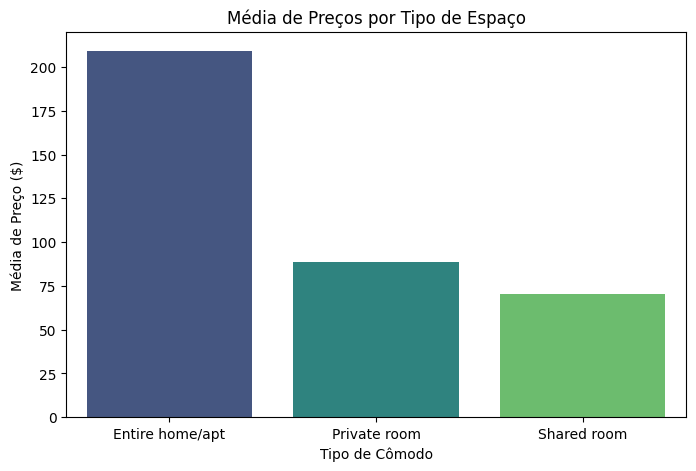

In [43]:
# Plotando o gráfico das médias dos distritos (preço)
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_room_type.index, y=mean_room_type.values, palette="viridis")
plt.xlabel("Tipo de Cômodo")
plt.ylabel("Média de Preço ($)")
plt.title("Média de Preços por Tipo de Espaço")
plt.xticks(rotation=0)
plt.show()

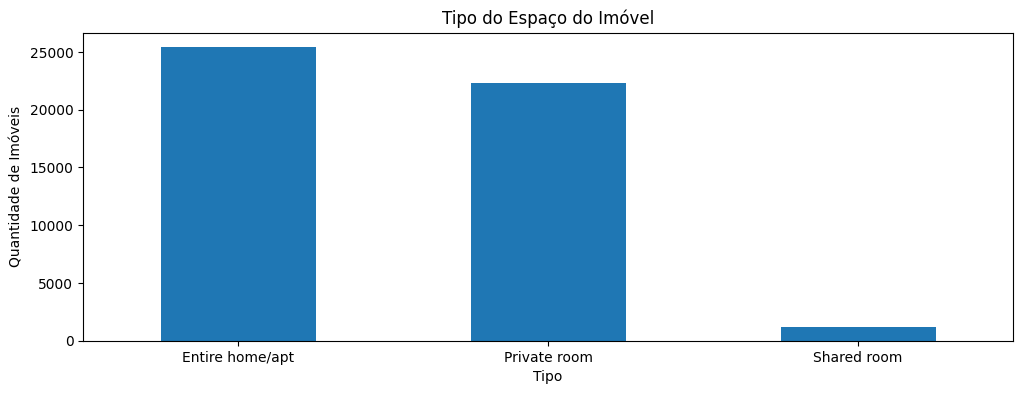

In [44]:
# Plotando gráfico do tipo de espaço do imóvel
plt.figure(figsize=(12, 4))
df_categorical_columns['room_type'].value_counts().plot(kind='bar')
plt.title('Tipo do Espaço do Imóvel')
plt.xlabel('Tipo')
plt.ylabel('Quantidade de Imóveis')
plt.xticks(rotation=0)
plt.show()

In [45]:
# Teste ANOVA
for col in categorical_columns:
  df = dataframe.copy()
  df = df.dropna(subset=['price', col])

  groups = [df[df[col] == categorical]['price'] for categorical in df[col].unique()]
  anova_result = f_oneway(*groups)

  print(f'{col} - P-Valor da ANOVA:', anova_result.pvalue)

nome - P-Valor da ANOVA: 7.311695396274974e-216
host_name - P-Valor da ANOVA: 4.38292497384437e-159
bairro_group - P-Valor da ANOVA: 0.0
bairro - P-Valor da ANOVA: 0.0
room_type - P-Valor da ANOVA: 0.0
ultima_review - P-Valor da ANOVA: 2.0173951198821963e-262


Segundo o teste de ANOVA, podemos dizer baseado nos P-valores que as variáveis `bairro_group`, `bairro` e `room_type` influenciam diretamente na variável objetivo `price`. Isso significa que o preço varia bastante dependendo da localização e do tipo de acomodação.

Em contrapartida, as demais variáveis não possuem grande significância para a variável objetivo. Dado isso e as correlações feitas acima com as variáveis numéricas, estarei dropando, no pré-processamento essas variáveis.

## Valores Nulos e Duplicados

In [46]:
dataframe.duplicated().sum()

0

In [47]:
# Verificando a ocorrência de valores nulos
dataframe.isnull().sum()

,0
id,0
nome,16
host_id,0
host_name,21
bairro_group,0
bairro,0
latitude,0
longitude,0
room_type,0
price,0


## Engenharia de Atributos




A partir dos resultados que obtive em testes e baseado nas correlações acima, as variáveis presentes no dataset não são suficientes para explicar a variável objetivo, dessa forma, para aumentar o desempenho do modelo estarei fazendo uma engenharia de atributos criando novas colunas a partir das existentes.

  - Variáveis criadas na EDA:

In [48]:
dataframe['mean_price_district'] = dataframe['bairro_group'].map(mean_prices)

In [49]:
dataframe['mean_price_room_type'] = dataframe['room_type'].map(mean_room_type)

In [50]:
dataframe['mean_price_bairro'] = dataframe['bairro'].map(mean_bairro_prices2)

  - Novas features:

In [51]:
# Tempo desde a última review
dataframe['ultima_review'] = pd.to_datetime(dataframe['ultima_review'])
dataframe['time_since_last_review'] = (pd.to_datetime('today') - dataframe['ultima_review']).dt.days
dataframe['time_since_last_review'].fillna(1000, inplace=True)

In [52]:
# Definindo classes para disponibilidade e seus dias
def classificacao_disponibilidade(dias):
    if dias <= 30:
        return 'Baixa'
    elif dias <= 60:
        return 'Média'
    else:
        return 'Alta'

dataframe['status_disponibilidade'] = dataframe['disponibilidade_365'].apply(classificacao_disponibilidade)

In [53]:
# Definindo classes para verificar a popularidade do host
def host_popularidade(quantidade_anuncios):
    if quantidade_anuncios <= 5:
        return 'Baixa'
    elif quantidade_anuncios <= 10:
        return 'Médio'
    else:
        return 'Alto'

dataframe['host_popularity'] = dataframe['calculado_host_listings_count'].apply(host_popularidade)

In [54]:
dataframe.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,mean_price_district,mean_price_room_type,mean_price_bairro,time_since_last_review,status_disponibilidade,host_popularity
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2019-05-21,0.38,2,355,194.431976,209.416614,282.719094,2086.0,Alta,Baixa
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,NaT,NaN,1,365,194.431976,88.586242,118.974041,1000.0,Alta,Baixa
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,2019-07-05,4.64,1,194,123.187049,209.416614,168.201401,2041.0,Alta,Baixa
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,2018-11-19,0.10,1,0,194.431976,209.416614,124.358423,2269.0,Baixa,Baixa
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,2019-06-22,0.59,1,129,194.431976,209.416614,221.415289,2054.0,Alta,Baixa


## Respostas das Perguntas

**a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?**


Baseado na média de preços dos apartamentos e pesquisando sobre os cinco distritos, a resposta para essa pergunta é um *depende*. Se você está procurando apartamento em um local como centro e tem condições de pagar um preço um pouco mais salgado, então a escolha pode ser em Manhattan, que é também o local com maior concentração de anúncios. Caso contrário, o Brooklyn ou Queens possuem aluguéis mais em conta e ótimas oportunidades de alugel.

**b. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?**

Baseado nos gráficos de correlação linear e monotônico, percebe-se que as variáveis `minimo_noites`e `disponibilidade_365` tem um impacto bem pequeno na variável `price`, ou seja, a cada vez que os dias nessas variáveis aumentam, o preço sofre uma pequena alteração. Vale lembrar que o impacto, baseado na correlação, não será grande como de outras variáveis.

**c. Existe algum padrão no texto do nome do local para lugares de mais alto valor?**

Percebe-se, analisando os 10 apartamentos mais caros, que o nome deles possuem um padrão de palavras como *Luxury*, *Tribeca* ou *SuperBowl* que indicam que esses apartamentos são de alto valor, não só pela palavra como pelo nome do bairro que é conhecidamente mais caro (Tribeca) e nome de um dos eventos mais assistidos pelos americanos que é o SuperBowl.

# Modelagem

Baseado nas associações entre as variáveis com o teste de ANOVA para as categóricas, e de Pearson e Spearman para as numéricas, estarei dropando algumas colunas do dataset que na minha visão não agregarão ao meu modelo. Inicialmente, pensei em fazer o teste das variáveis que mais impactariam o meu modelo com o Shap Values, mas acredito que com as correlações e testes acima já será suficiente, até mesmo pela pouca quantidade de variáveis.

Pensando nisso, estarei utilizando oito features, sendo elas:
  - bairro_group
  - bairro
  - latitude
  - longitude
  - room_type
  - minimo_noites
  - numero_de_reviews
  - disponibilidade_365
  - mean_price_district
  - mean_price_room_type

E a variável objetivo será **price**.

In [55]:
dataframe.shape

(48873, 22)

## Separação das Variáveis

In [56]:
dataframe.head(1)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,mean_price_district,mean_price_room_type,mean_price_bairro,time_since_last_review,status_disponibilidade,host_popularity
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2019-05-21,0.38,2,355,194.431976,209.416614,282.719094,2086.0,Alta,Baixa


Com o objetivo de não só não enviezar o meu modelo, mas também evitar *data leakage* estarei fazendo a separação dos dados antes de realizar o pré-processamento, evitando também um possível overfitting.

In [57]:
X = dataframe[['bairro_group', 'bairro', 'latitude', 'longitude', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'mean_price_district', 'mean_price_room_type', 'mean_price_bairro', 'time_since_last_review', 'status_disponibilidade', 'host_popularity']]

In [58]:
y = dataframe['price']

In [59]:
X.head(1)

,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,mean_price_district,mean_price_room_type,mean_price_bairro,time_since_last_review,status_disponibilidade,host_popularity
0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,0.38,194.431976,209.416614,282.719094,2086.0,Alta,Baixa


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
X_train.shape, X_test.shape

((39098, 14), (9775, 14))

In [62]:
y_train.shape, y_test.shape

((39098,), (9775,))

## Pré-Processamento

Um ponto importante a ser destacado, é que estarei utilizando o algoritmo de **TargetEncoder** e **OneHotEncoder** para fazer a codificação de rótulos. A escolha dessa primeira técnica se deu porque estarei utilizando algoritmos baseados em árvores e esses algoritmos não atribuem relações ordinais nas variáveis, ou seja, aquele problema que o TargetEncoder pode gerar não afetará o meu modelo. Para as variáveis com poucas categorias, estarei utilizando o OneHotEncoder, para as demais estarei utilizando o TargetEncoder.

In [63]:
# Verificando a ocorrência de categorias
categorical_variables = dataframe.select_dtypes(include=['object', 'category'])
n_categorical = categorical_variables.nunique()
print(n_categorical)

nome                      47883
host_name                 11449
bairro_group                  5
bairro                      221
room_type                     3
status_disponibilidade        3
host_popularity               3
dtype: int64


In [64]:
# Aplicando OneHotEncoder com o GetDummies
X_train = pd.get_dummies(X_train, columns=['bairro_group', 'room_type', 'status_disponibilidade', 'host_popularity'])
X_test = pd.get_dummies(X_test, columns=['bairro_group', 'room_type', 'status_disponibilidade', 'host_popularity'])

In [65]:
# Aplicando TargetEncoder na coluna bairro
target_encoder = ce.TargetEncoder(cols=['bairro'])
X_train['bairro'] = target_encoder.fit_transform(X_train['bairro'], y_train)
X_test['bairro'] = target_encoder.transform(X_test['bairro'])

In [66]:
X_train.dtypes

,0
bairro,float64
latitude,float64
longitude,float64
minimo_noites,int64
numero_de_reviews,int64
reviews_por_mes,float64
mean_price_district,float64
mean_price_room_type,float64
mean_price_bairro,float64
time_since_last_review,float64


In [67]:
# Convertendo de boolean para int
for col in X_train.columns:
    if X_train[col].dtype == "bool":
        X_train[col] = X_train[col].astype(int)
        X_test[col] = X_test[col].astype(int)

In [68]:
X_train.shape, X_test.shape

((39098, 24), (9775, 24))

## Tratando Valores Nulos

In [69]:
X_train.isnull().sum()

,0
bairro,0
latitude,0
longitude,0
minimo_noites,0
numero_de_reviews,0
reviews_por_mes,8057
mean_price_district,0
mean_price_room_type,0
mean_price_bairro,0
time_since_last_review,0


In [70]:
# Inserindo valor 0 nas reviews com valor faltante
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

Outro ponto a ser observado, é que como foi dito acima estarei usando algoritmos baseados em árvores, dessa forma a *normalização* dos dados não será necessária pois não afetará o modelo.

Ademais, não houve tratamento de valores nulos de algumas variáveis, uma vez que nas variáveis selecionadas não existem valores nulos.

## Verificando Correlação Monotônica

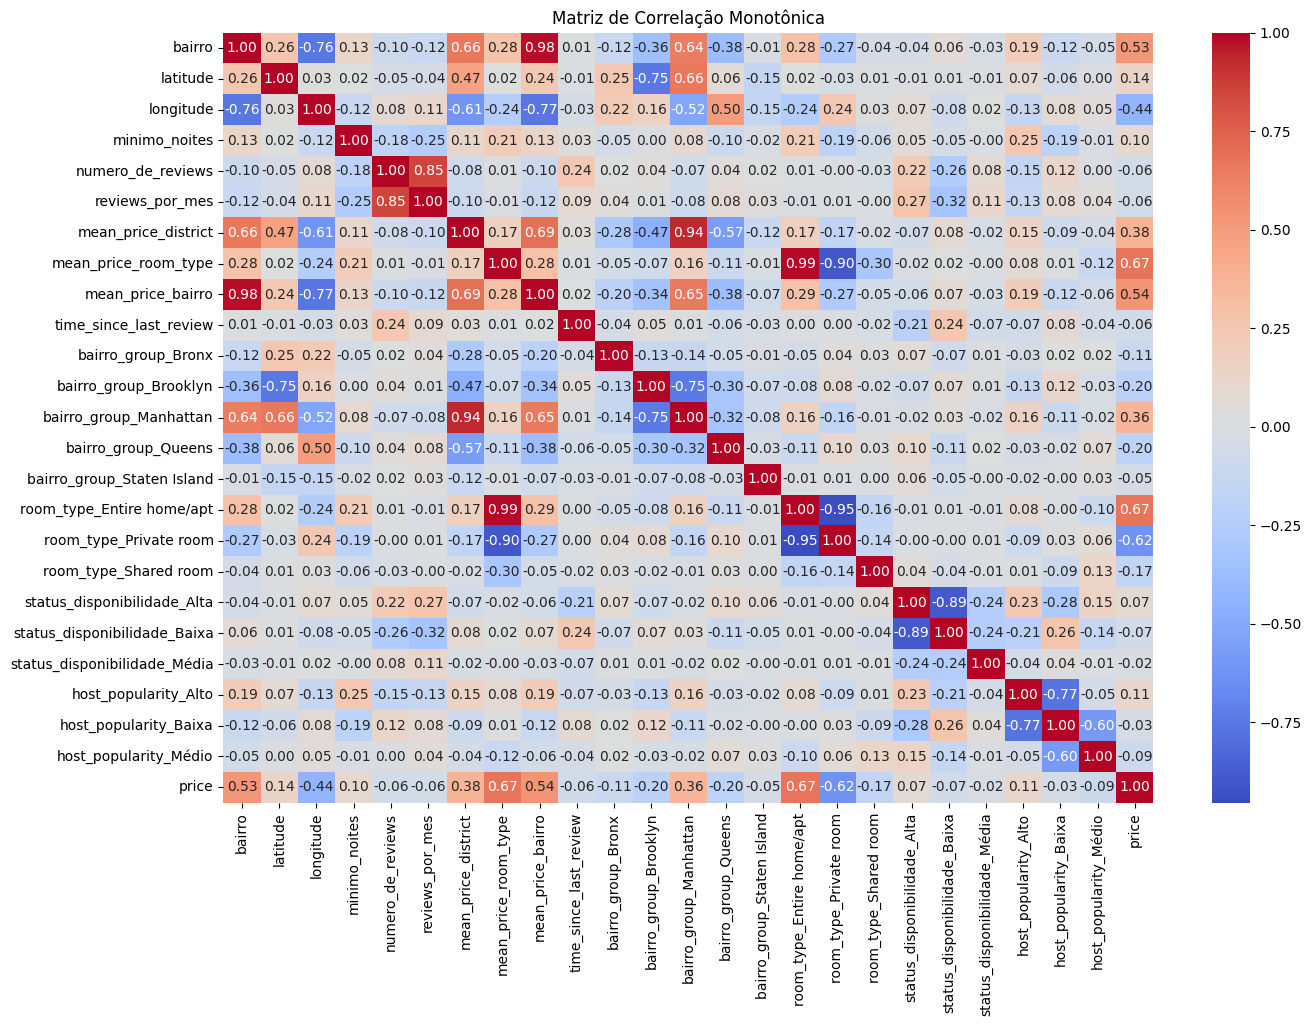

In [71]:
# Plotando novo gráfico de Correlação de Spearman para verificar as associações após transformações
correlation_df = X_train.copy()
correlation_df['price'] = y_train

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_df.corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlação Monotônica')
plt.show()

# Criação e Treinamento dos Modelos

O objetivo do desafio é realizar a previsão da precificação de aluguéis, esse problema se classifica como previsão com regressão, uma vez que estamos prevendo números e não classes.

Baseado nisso, estarei usando algoritmos de regressão baseados em árvores, como: `RandomForest`, `DecisionTree` e `XGBoost`. Essa escolha se justifica pela robustez desses algoritmos que, na minha experiência, sempre retornaram as melhores performances em problemas de regressão. Optei por não utilizar Regressão Linear, visto que na correlação de Pearson os resultados das associações foram insignificantes.

Estarei treinando os modelos com os 4 algoritmos e verificando o desempenho com métricas posteriormente.

In [72]:
# Criando uma lista dos modelos que serão treinados
models = [
    (RandomForestRegressor(n_estimators=500, max_depth=20, random_state=0, n_jobs=-1), "RandomForest"),
    (DecisionTreeRegressor(max_depth=10, random_state=0), "DecisionTree"),
    (XGBRegressor(n_estimators=500, max_depth=15, learning_rate=0.1, random_state=0, verbosity=0), "XGBoost"),
    (GradientBoostingRegressor(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=0), "GradientBoosting")
]

In [73]:
# Treinando os modelos
predictions = {}
trained_models = {}

for model, name in tqdm(models, desc="Treinando Modelos Baseados em Árvores", unit="model"):
    model.fit(X_train, y_train)
    trained_models[name] = model
    predictions[name] = model.predict(X_test)

Treinando Modelos Baseados em Árvores: 100%|██████████| 4/4 [04:59<00:00, 74.82s/model]


## Avaliando a Performance dos Modelos

Para fazer a avaliação da performance dos modelos treinados acima, estarei utilizando quatro métricas comuns em problemas de regressão, são elas:

  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)

O uso do conjunto MSE e MAE, se da porque são complementares, um avalia sem punir outliers (MAE) e o outro já pune erros grandes gerados por outliers (MSE). O RMSE mostra o quão distantes as previsões estão em média em relação aos valores reais (y_test).

In [74]:
# Calculando Métricas
metrics = []

for name in predictions:
  y_pred = predictions[name]

  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  metrics.append({
        'Modelo': name,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
    })

df_results = pd.DataFrame(metrics)
print(df_results)

             Modelo           MSE        MAE        RMSE
0      RandomForest  25048.725909  61.753148  158.267893
1      DecisionTree  33079.649014  62.977335  181.878116
2           XGBoost  37755.789062  67.206650  194.308489
3  GradientBoosting  27167.202327  63.610793  164.824762


Baseado nas métricas acima, o modelo que melhor se aproxima dos dados e teve melhor desempenho foi o de **RandomForest**. Algumas vantagens desse algoritmo é que ele é robusto, o que faz com que ele consiga reduzir o overfitting, além disso ele consegue desempenhar bem com vários tipos de dados. Em contrapartida, pode ser de difícil interpretação pois gera muitas árvores, e se for passado um conjunto muito grande de dados pode ser custoso. Escolhi duas medidas principais para avaliar o desempenho e escolher o melhor, que foram o MAE E O RMSE, elas foram escolhidas pois o MAE não pune erros devido a outliers e o RMSE mostra a distância dos valores reais.

# Tunagem do Modelo Vencedor

In [75]:
# O processo de Tuning será feito com o RandomizedSearchCV

# Distribuindo os hiperparâmetros para teste
param_distributions = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Criação do modelo
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

# Configurando o RandomSearch
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,  # Número de combinações a testar
    scoring='neg_mean_absolute_error',  # Critério de avaliação
    cv=5,  # Validação cruzada com 5 folds
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Treinamento do modelo
random_search.fit(X_train, y_train)
print("Melhores parâmetros:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}


A partir da Tunagem feita acima, com os novos melhores parâmetros, estarei treinando novamente o meu modelo de RandomForest.

In [76]:
best_model = RandomForestRegressor(**random_search.best_params_, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [77]:
# Avaliando no conjunto de teste
y_final_pred = best_model.predict(X_test)
y_final_pred

array([122.00622642,  58.26409506, 182.42450734, ..., 231.19000583,
        90.87245199, 170.96781879])

In [78]:
# Avaliando a performance
final_mae = mean_absolute_error(y_test, y_final_pred)
final_mse = mean_squared_error(y_test, y_final_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_final_pred)

print("Métricas no Conjunto de Teste:")
print(f"MAE  (Mean Absolute Error): {final_mae:.2f}")
print(f"MSE  (Mean Squared Error): {final_mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {final_rmse:.2f}")
print(f"R²   (Coeficiente de Determinação): {final_r2:.4f}")

Métricas no Conjunto de Teste:
MAE  (Mean Absolute Error): 58.95
MSE  (Mean Squared Error): 21832.87
RMSE (Root Mean Squared Error): 147.76
R²   (Coeficiente de Determinação): 0.2406


Baseado nas métricas, entende-se que o modelo desempenha razoavelmente bem, apesar de ter o R² baixo (que pode ser justificado pelo dataset), as métricas de MAE, MSE E RMSE estão baixas considerando o preço de um aluguel de ímoveis. Dessa forma, o MAE indica que o meu modelo erra em média 58,95 doláres para cima ou para baixo, o que é uma boa métrica.

# Novos Dados

In [79]:
X_train.head(1)

,bairro,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,mean_price_district,mean_price_room_type,mean_price_bairro,time_since_last_review,...,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,status_disponibilidade_Alta,status_disponibilidade_Baixa,status_disponibilidade_Média,host_popularity_Alto,host_popularity_Baixa,host_popularity_Médio
39888,119.125144,40.79745,-73.93834,2,1,0.18,194.431976,209.416614,124.358423,2205.0,...,0,1,0,0,0,1,0,0,1,0


In [80]:
# Novos Dados
data = {
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355,
    'mean_price_district': 194.431976,
    'mean_price_room_type': 209.416614,
    'mean_price_bairro': 282.719094,
    'time_since_last_review': 0,
    'status_disponibilidade': 'Alta',
    'host_popularity': 'Alta'
}

new_data = pd.DataFrame([data])

# Aplicando as mesmas transformações
new_data['bairro'] = target_encoder.transform(new_data['bairro'])
new_data = pd.get_dummies(new_data, columns=['bairro_group', 'room_type', 'status_disponibilidade', 'host_popularity'])

# Garantindo que não haja divergência entre os dados novos e o x_train
faltando = set(X_train.columns) - set(new_data.columns)
for col in faltando:
    new_data[col] = 0

new_data = new_data[X_train.columns]


In [81]:
# Fazendo as previsões e avaliando

new_predict = best_model.predict(new_data)
print(f'Previsão do Preço: {new_predict[0]}')

Previsão do Preço: 447.26952228032906


# Salvando Modelo

In [82]:
from joblib import dump
dump(best_model, 'random_forest.pkl', compress=9)

['random_forest.pkl']